# Idea: Fit a gaussian to the squeezed coherent statess that are part of the cat to extract all informatin we care about. Displacement amplitude and degree of squeezing.

### 1. Import packages an implement helper functions



In [2]:
########################  2D plot ##################
import h5py
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = tensor(destroy(N), qeye(2))
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2




### 2. Import post selection data and make a quick plot.

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

if 1:
    filepath = r"C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\cat_decay_data\085533_panther_cat_fringe_decay.h5"
    file = h5py.File(filepath, "r")
    data = file["data"]
    data_i = data["I"][:]
    # state = data["state"][:]
    x_data = data["x"][:, 0][:, 0]
    n_points = len(x_data)  # sweep points
    thresh = 1.736310313628283e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m1 = ss_data[:, 0::2]  # .mean(axis=0) # first measurement, we use as mask
    m2 = ss_data[:, 1::2]  # .mean(axis=0) # second measurement
    mask = np.zeros_like(m1)
    mx_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    mx_e = (
        ma.masked_array(m2, mask=np.logical_not(m1))
        .mean(axis=0)
        .reshape(n_points, n_points)
    ) * 2 - 1
    mx_ge = m2.mean(axis=0).reshape(n_points, n_points) * 2 - 1

    # # test = m1.mean(axis=0).reshape(31, 31)
#     fig, ax = plt.subplots()
    proj_ge = [mx_g, mx_e, mx_ge]  # m2.mean(axis = 0).reshape(n_points, n_points)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    f1 = ax1.pcolormesh(x_data, x_data, mx_g, cmap="seismic", vmax=1, vmin=-1)
    f2 = ax2.pcolormesh(x_data, x_data, mx_e, cmap="seismic", vmax=1, vmin=-1)
    ax1.set_aspect("equal")
    ax1.set_xlabel(r"real($\beta$)")
    ax1.set_ylabel(r"imag($\beta$)")
    ax2.set_aspect("equal")
    ax2.set_xlabel(r"real($\beta$)")


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\cat_decay_data\085533_panther_cat_fringe_decay.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Lets make a larger plot of the data we will analyse, mx_e

Text(28.0, 0.5, 'imag($\\beta$)')

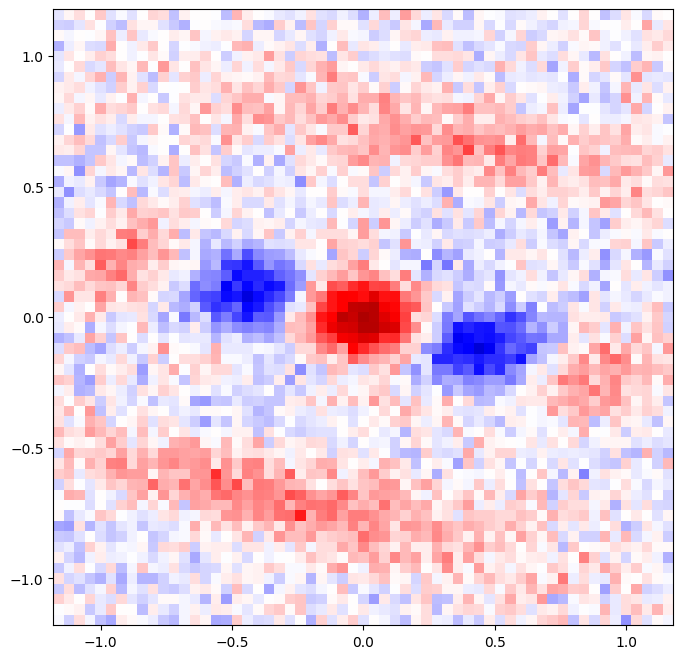

In [3]:
# plot single state
fig, ax = plt.subplots(figsize=(8,8))
f1 = ax.pcolormesh(x_data, x_data, mx_g, cmap="seismic", vmax=1, vmin=-1)

ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")

### 3. Fit Gaussians to squeezed blobs and extract the plot information

In [1]:
from tcsim.analyze.fit_funcs.gaussian import func

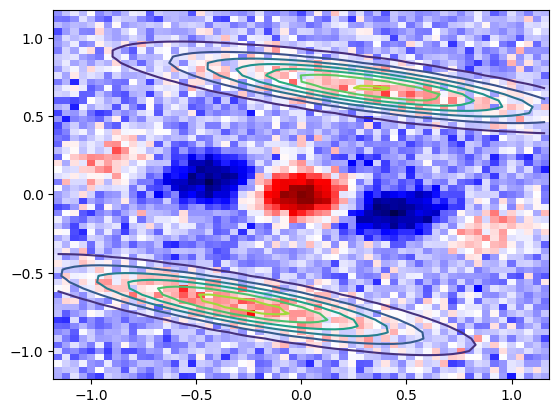

In [4]:
""" 
Use the above plot to make good intial guesses!

"""

# add some noise to the data and try to fit the data generated beforehand
initial_guess1 = (0.3, -0.2, 0.8, 0.6, 0.1, -np.pi/16, 0) # upper blob
initial_guess2 = (0.3, -0.2, -0.8, 0.6, 0.1, -np.pi/16, 0) # lower blob

x = x_data[:] # i define it like this in case i want to slice x
y = x_data[:]
X, Y = np.meshgrid(x, y)

data = mx_g.data[:][:]

popt1, pcov1 = opt.curve_fit(func, (X, Y), data.flatten(), p0=initial_guess1)

popt2, pcov2 = opt.curve_fit(func, (X, Y), data.flatten(), p0=initial_guess2)


data_fitted1 = func((X, Y), *popt1)
data_fitted2 = func((X, Y), *popt2)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic")
ax.contour(x,y, data_fitted1.reshape(len(y),len(x)))
ax.contour(x,y, data_fitted2.reshape(len(y),len(x)))
plt.show()

In [5]:
""" quick note: while the sigma ratio can be easily extracted, extracting the displacement isnt as straight forward. 

1. For a cat state visualized with the characteristic function, the blobs are positioned at 2*alpha and -2*alpha. 

2. The x,y scale of the experimental data is not exact but only approximate yet. Hence, any alpha extracted from the data has to be corrected with the correct scaling factor.


 """
print("First Blob")
print('xcenter:',popt1[1])
print('ycenter:',popt1[2])
print('|distance from origin| =',np.sqrt(popt1[1]**2+popt1[2]**2))
print("sigma ratio:",(popt1[3]/popt1[4]))
print('angle in degree:', np.rad2deg(popt1[5]))
print("----------------")
print("Second Blob")
print('xcenter:',popt2[1])
print('ycenter:',popt2[2])
print('|distance from origin| =',np.sqrt(popt2[1]**2+popt2[2]**2))
print("sigma ratio:",(popt2[3]/popt2[4]))
print('angle in degree:', np.rad2deg(popt2[5]))

print("----------------")
print("averaged values")
print('|distance from origin averaged| =',(np.sqrt((popt1[1]**2+popt1[2]**2))+ np.sqrt(popt2[1]**2+popt2[2]**2))/2)
print("sigma ratio averaged:" ,((popt1[3]/popt1[4]) + (popt2[3]/popt2[4]))/2 )
print('angle in degree averaged:', (np.rad2deg(popt1[5])+np.rad2deg(popt2[5]))/2)


First Blob
xcenter: 0.3248895460148151
ycenter: 0.6830488467388912
|distance from origin| = 0.7563788363915545
sigma ratio: 6.535565490997043
angle in degree: 10.295936479544032
----------------
Second Blob
xcenter: -0.28094337076290526
ycenter: -0.7032749841289472
|distance from origin| = 0.7573142550336645
sigma ratio: 6.104445916175143
angle in degree: 13.481549726363665
----------------
averaged values
|distance from origin averaged| = 0.7568465457126095
sigma ratio averaged: 6.320005703586093
angle in degree averaged: 11.88874310295385


In [7]:
""" quick note: while the sigma ratio can be easily extracted, extracting the displacement isnt as straight forward. 

1. For a cat state visualized with the characteristic function, the blobs are positioned at 2*alpha and -2*alpha. 

2. The x,y scale of the experimental data is not exact but only approximate yet. Hence, any alpha extracted from the data has to be corrected with the correct scaling factor.


 """
print("First Blob")
print('xcenter:',popt1[1])
print('ycenter:',popt1[2])
print('|distance from origin| =',np.sqrt(popt1[1]**2+popt1[2]**2))
print("sigma ratio:",(popt1[3]/popt1[4]))
print('angle in degree:', np.rad2deg(popt1[5]))
print("----------------")
print("Second Blob")
print('xcenter:',popt2[1])
print('ycenter:',popt2[2])
print('|distance from origin| =',np.sqrt(popt2[1]**2+popt2[2]**2))
print("sigma ratio:",(popt2[3]/popt2[4]))
print('angle in degree:', np.rad2deg(popt2[5]))

print("----------------")
print("averaged values")
print('|distance from origin averaged| =',(np.sqrt((popt1[1]**2+popt1[2]**2))+ np.sqrt(popt2[1]**2+popt2[2]**2))/2)
print("sigma ratio averaged:" ,((popt1[3]/popt1[4]) + (popt2[3]/popt2[4]))/2 )
print('angle in degree averaged:', (np.rad2deg(popt1[5])+np.rad2deg(popt2[5]))/2)


First Blob
xcenter: -0.07636241764497317
ycenter: 0.7798525055562597
|distance from origin| = 0.7835822542981441
sigma ratio: 6.573926378647599
angle in degree: -21.67989352072571
----------------
Second Blob
xcenter: 0.09739941318953871
ycenter: -0.7734126540714207
|distance from origin| = 0.7795215065458204
sigma ratio: 6.268735819547789
angle in degree: -21.417665297755118
----------------
averaged values
|distance from origin averaged| = 0.7815518804219823
sigma ratio averaged: 6.421331099097694
angle in degree averaged: -21.548779409240414


### 4. create theoretical plot with data to see if it makes sense

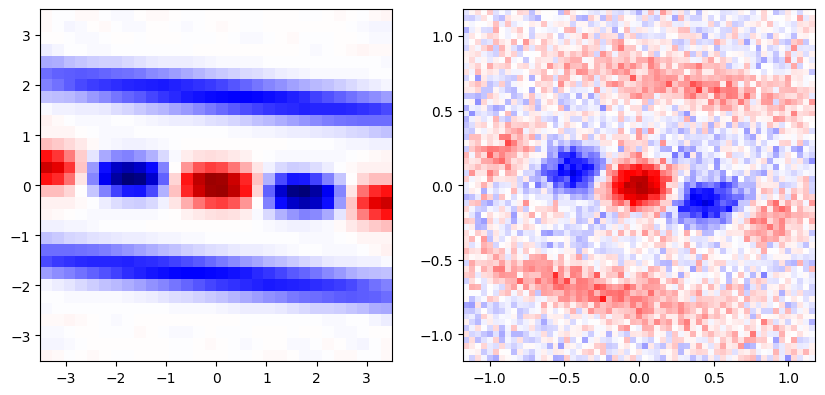

In [37]:
## tryout intelligent guesses to find a similair looking state to start out form
squeezing_db = 12
displacement = 0.9
angle = np.deg2rad(11.8)

xvec = np.linspace(-3.4,3.4,30)

state = ((displace(N,displacement*np.exp(1j*angle))-displace(N,-displacement*np.exp(1j*angle)))*squeeze(N,calc_squeez_parameter(squeezing_db*np.exp(1j*angle)))*fock(N,0)).unit()
         
cf_real, cf_imag = char_func_grid(state,xvec)

fig, ax = plt.subplots(1,2, figsize=(10,10))
cs1= ax[0].pcolormesh(xvec, xvec, cf_real, cmap = 'seismic', vmin=-1, vmax=1, shading='auto')
ax[1].pcolormesh(X,Y, data, cmap = 'seismic', vmin=-1, vmax=1, shading='auto')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [26]:
displacement*(np.cosh(calc_squeez_parameter(squeezing_db))+np.sinh(calc_squeez_parameter(squeezing_db)))

2.5071553570248475

In [16]:
from qutip import*
import numpy as np
N = 50
a = destroy(N)

In [17]:
print(ry(-np.pi/2)*ry(np.pi)*ry(-np.pi/2))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


C:\Users\jonat\AppData\Local\Temp\ipykernel_3044\4284515689.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  print(ry(-np.pi/2)*ry(np.pi)*ry(-np.pi/2))


In [19]:
state  = (coherent(N,2) + coherent(N,-2)).unit()
expect(a.dag()*a,state)

3.9973171989562655